In [383]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import geopandas as gpd
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [384]:
df_ipc=pd.read_csv("Data/ethiopia_admin1_fewsnet_population_2020.csv",index_col=0)
adm1c='ADM1_EN' #"ADMIN1" #

In [385]:
# df_ipc.equals(df_ipc2)
# a=pd.concat([df_ipc,df_ipc2]).drop_duplicates(keep=False)

In [386]:
# df_ipc=pd.read_csv("Data/ethiopia_admin1_fewsnet_population.csv",index_col=0)
# adm1c="ADMIN1" 

In [387]:
df_ipc.head()

date           ADM1_EN     Total  adjusted_population       CS_1  \
0  2009-07-01       Addis Ababa   3585647              2726821        NaN   
1  2009-07-01              Afar   1904414              1448271        0.0   
2  2009-07-01            Amhara  21790172             16571038  9531637.0   
3  2009-07-01  Benishangul Gumz   1102849               838696   838696.0   
4  2009-07-01         Dire Dawa    508918               387022        0.0   

        CS_2       CS_3  CS_4  CS_5      ML1_1  ...  ML1_4  ML1_5      ML2_1  \
0        NaN        NaN   NaN   NaN        NaN  ...    NaN    NaN        NaN   
1   702984.0   745287.0   0.0   0.0        0.0  ...    0.0    0.0        0.0   
2  1743855.0  5295546.0   0.0   0.0  9531637.0  ...    0.0    0.0  7609926.0   
3        0.0        0.0   0.0   0.0   838696.0  ...    0.0    0.0   838696.0   
4   387022.0        0.0   0.0   0.0        0.0  ...    0.0    0.0        0.0   

       ML2_2     ML2_3  ML2_4  ML2_5      pop_CS     pop_ML1     pop_ML2  
0        NaN       NaN    NaN    NaN         NaN         NaN         NaN  
1   862230.0  586041.0    0.0    0.0   1448271.0   1448271.0   1448271.0  
2  8961112.0       0.0    0.0    0.0  16571038.0  16571038.0  16571038.0  
3        0.0       0.0    0.0    0.0    838696.0    838696.0    838696.0  
4   387022.0       0.0    0.0    0.0    387022.0    387022.0    387022.0  

[5 rows x 22 columns]

In [388]:
def get_trigger(row, status, level, perc):
    # range till 6 cause 5 is max level
    cols = [f"{status}_{l}" for l in range(level, 6)]
    if np.isnan(row[f"pop_{status}"]):
        return np.nan
    if row[cols].sum() >= row[f"pop_{status}"] / (100 / perc):
        return 1
    else:
        return 0


def get_trigger_increase(row, level, perc):
    # range till 6 cause 5 is max level
    cols_ml1 = [f"ML1_{l}" for l in range(level, 6)]
    cols_cs = [f"CS_{l}" for l in range(level, 6)]
    if row[["pop_CS", "pop_ML1"]].isnull().values.any():
        return np.nan
    if row[cols_ml1].sum() == 0:
        return 0
    if row[cols_ml1].sum() >= row[cols_cs].sum() * (1 + (perc / 100)):
        return 1
    else:
        return 0

In [389]:
df_ipc['date'] = pd.to_datetime(df_ipc['date'])
df_ipc['year'] = df_ipc['date'].dt.year
df_ipc['month'] = df_ipc['date'].dt.month

In [390]:
df_ipc["trigger_CS_3_20"]=df_ipc.apply(lambda x: get_trigger(x,"CS",3,20),axis=1)
df_ipc["trigger_CS_4_2"]=df_ipc.apply(lambda x: get_trigger(x,"CS",4,2.5),axis=1)
df_ipc["trigger_CS_4_20"]=df_ipc.apply(lambda x: get_trigger(x,"CS",4,20),axis=1)
df_ipc["trigger_CS_4_1"]=df_ipc.apply(lambda x: get_trigger(x,"CS",4,0.1),axis=1)
df_ipc["trigger_ML1_3_5"]=df_ipc.apply(lambda x: get_trigger(x,"ML1",3,5),axis=1)
df_ipc["trigger_ML1_4_2"]=df_ipc.apply(lambda x: get_trigger(x,"ML1",4,2.5),axis=1)
df_ipc["trigger_ML1_3_30"]=df_ipc.apply(lambda x: get_trigger(x,"ML1",3,30),axis=1)
df_ipc["trigger_ML1_3_5i"]=df_ipc.apply(lambda x: get_trigger_increase(x,3,5),axis=1)

In [391]:
for c in ["CS_3","CS_4","ML1_3","ML1_4"]:
    status=c.split("_")[0]
    df_ipc[f"perc_{c}"]=df_ipc[c]/df_ipc[f"pop_{status}"]*100

In [392]:
df_ipc.head()

date           ADM1_EN     Total  adjusted_population       CS_1  \
0 2009-07-01       Addis Ababa   3585647              2726821        NaN   
1 2009-07-01              Afar   1904414              1448271        0.0   
2 2009-07-01            Amhara  21790172             16571038  9531637.0   
3 2009-07-01  Benishangul Gumz   1102849               838696   838696.0   
4 2009-07-01         Dire Dawa    508918               387022        0.0   

        CS_2       CS_3  CS_4  CS_5      ML1_1  ...  trigger_CS_4_20  \
0        NaN        NaN   NaN   NaN        NaN  ...              NaN   
1   702984.0   745287.0   0.0   0.0        0.0  ...              0.0   
2  1743855.0  5295546.0   0.0   0.0  9531637.0  ...              0.0   
3        0.0        0.0   0.0   0.0   838696.0  ...              0.0   
4   387022.0        0.0   0.0   0.0        0.0  ...              0.0   

   trigger_CS_4_1  trigger_ML1_3_5  trigger_ML1_4_2  trigger_ML1_3_30  \
0             NaN              NaN              NaN               NaN   
1             0.0              1.0              0.0               1.0   
2             0.0              1.0              0.0               1.0   
3             0.0              0.0              0.0               0.0   
4             0.0              0.0              0.0               0.0   

   trigger_ML1_3_5i  perc_CS_3  perc_CS_4  perc_ML1_3  perc_ML1_4  
0               NaN        NaN        NaN         NaN         NaN  
1               0.0  51.460466        0.0   51.460466         0.0  
2               0.0  31.956634        0.0   31.956634         0.0  
3               0.0   0.000000        0.0    0.000000         0.0  
4               0.0   0.000000        0.0    0.000000         0.0  

[5 rows x 36 columns]

### Data analysis

In [432]:
def get_projection(row, df,col,adm2c="ADM2_EN",adm1c="ADM1_EN"):
#     print(row)
    possible_dates=[row["date"]+pd.DateOffset(months=m) for m in [2,3,4]]
#     print(possible_dates)
    try:
        act=df[df["date"].isin(possible_dates)]
#         print(act.columns)
#         actual = df.loc[(df[adm1col]==row[adm1col])&(df[adm2c]==row[adm2c])&(df['date']).isin(possible_dates)]
        return act[col].values[0]
    except:
        return None

In [433]:
df_nat=df_ipc.groupby("date",as_index=False).sum()

In [434]:
df_nat["actual_CS3"]=df_nat.apply(lambda x: get_projection(x,df_nat,"CS_3"),axis=1)

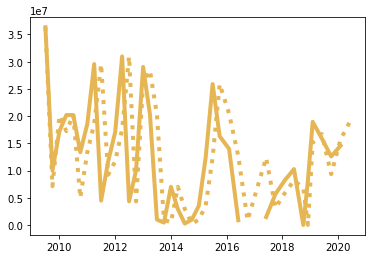

In [436]:
plt.plot(df_nat['date'],df_nat["actual_CS3"],label="IPC3", color='#E6B655', linewidth=4)
plt.plot(df_nat['date'],df_nat["ML1_3"],label="IPC3", color='#E6B655', linewidth=4,linestyle=":")

In [ ]:
count = 1
figure(figsize=(20, 60))
for region in somalia_reg['region'].unique():
    regional_df = somalia_reg.loc[somalia_reg['region'] == region]
    #reg_proj_df = reg_proj.loc[reg_proj['region'] == region]
    plt.subplot(10, 2, count)
    plt.plot(regional_df['date'], regional_df['ipc-3'], label='ipc-3', color='#E6B655', linewidth=4)
    plt.plot(regional_df['proj-start'], regional_df['proj-ipc-3'], label='proj. ipc-3', color='#E6B655', linewidth=4, linestyle=':')
    plt.plot(regional_df['date'], regional_df['ipc-4'], label='ipc-4', color='#CA7E8D', linewidth=4)
    plt.plot(regional_df['proj-start'], regional_df['proj-ipc-4'], label='proj. ipc-4', color='#CA7E8D', linewidth=4, linestyle=':')
    plt.plot(regional_df['date'], regional_df['ipc-5'], label='ipc-5', color='#9E6B55', linewidth=4)
    plt.title('Population at each IPC phase in ' + str(region))
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    for k, v in regional_df.iterrows():
        if v['threshold_reached'] == 1:
            plt.axvline(v['date'], linewidth=5, color='brown', alpha=0.5, linestyle='-.')
    #for k, v in regional_df.iterrows():
    #    if v['threshold_reached'] == 1:
    #        plt.axvspan(v['proj-start'], v['proj-end'], color='brown',
    #            alpha=0.25) 
    count += 1

In [438]:
df_ipc[df_ipc.ADM1_EN=="Addis Ababa"]

date      ADM1_EN    Total  adjusted_population       CS_1  CS_2  \
0   2009-07-01  Addis Ababa  3585647              2726821        NaN   NaN   
11  2009-10-01  Addis Ababa  3585647              2726821        NaN   NaN   
22  2010-01-01  Addis Ababa  3585647              2803796        NaN   NaN   
33  2010-04-01  Addis Ababa  3585647              2803796        NaN   NaN   
44  2010-07-01  Addis Ababa  3585647              2803796        NaN   NaN   
55  2010-10-01  Addis Ababa  3585647              2803796        NaN   NaN   
66  2011-01-01  Addis Ababa  3585647              2883776        NaN   NaN   
77  2011-04-01  Addis Ababa  3585647              2883776        NaN   NaN   
88  2011-07-01  Addis Ababa  3585647              2883776        NaN   NaN   
99  2011-10-01  Addis Ababa  3585647              2883776        NaN   NaN   
110 2012-01-01  Addis Ababa  3585647              2966541        NaN   NaN   
121 2012-04-01  Addis Ababa  3585647              2966541        NaN   NaN   
132 2012-07-01  Addis Ababa  3585647              2966541        NaN   NaN   
143 2012-10-01  Addis Ababa  3585647              2966541        NaN   NaN   
154 2013-01-01  Addis Ababa  3585647              3051602        NaN   NaN   
165 2013-04-01  Addis Ababa  3585647              3051602        NaN   NaN   
176 2013-07-01  Addis Ababa  3585647              3051602        NaN   NaN   
187 2013-10-01  Addis Ababa  3585647              3051602        NaN   NaN   
198 2014-01-01  Addis Ababa  3585647              3138252        NaN   NaN   
209 2014-04-01  Addis Ababa  3585647              3138252        NaN   NaN   
220 2014-07-01  Addis Ababa  3585647              3138252        NaN   NaN   
231 2014-10-01  Addis Ababa  3585647              3138252  3138252.0   0.0   
242 2015-01-01  Addis Ababa  3585647              3225949  3225949.0   0.0   
253 2015-04-01  Addis Ababa  3585647              3225949  3225949.0   0.0   
264 2015-07-01  Addis Ababa  3585647              3225949  3225949.0   0.0   
275 2015-10-01  Addis Ababa  3585647              3225949  3225949.0   0.0   
286 2016-02-01  Addis Ababa  3585647              3314505  3314505.0   0.0   
297 2016-06-01  Addis Ababa  3585647              3314505  3314505.0   0.0   
308 2016-10-01  Addis Ababa  3585647              3314505  3314505.0   0.0   
319 2017-06-01  Addis Ababa  3585647              3403972  3403972.0   0.0   
330 2017-10-01  Addis Ababa  3585647              3403972  3403972.0   0.0   
341 2018-02-01  Addis Ababa  3585647              3494335  3494335.0   0.0   
352 2018-06-01  Addis Ababa  3585647              3494335  3494335.0   0.0   
363 2018-10-01  Addis Ababa  3585647              3494335  3494335.0   0.0   
374 2018-12-01  Addis Ababa  3585647              3494335        NaN   NaN   
385 2019-02-01  Addis Ababa  3585647              3585647  3585647.0   0.0   
396 2019-06-01  Addis Ababa  3585647              3585647  3585647.0   0.0   
407 2019-10-01  Addis Ababa  3585647              3585647  3585647.0   0.0   
418 2020-02-01  Addis Ababa  3585647              3585647  3585647.0   0.0   
429 2020-06-01  Addis Ababa  3585647              3585647  3585647.0   0.0   

     CS_3  CS_4  CS_5      ML1_1  ...  trigger_CS_4_20  trigger_CS_4_1  \
0     NaN   NaN   NaN        NaN  ...              NaN             NaN   
11    NaN   NaN   NaN        NaN  ...              NaN             NaN   
22    NaN   NaN   NaN        NaN  ...              NaN             NaN   
33    NaN   NaN   NaN        NaN  ...              NaN             NaN   
44    NaN   NaN   NaN        NaN  ...              NaN             NaN   
55    NaN   NaN   NaN        NaN  ...              NaN             NaN   
66    NaN   NaN   NaN        NaN  ...              NaN             NaN   
77    NaN   NaN   NaN        NaN  ...              NaN             NaN   
88    NaN   NaN   NaN        NaN  ...              NaN             NaN   
99    NaN   NaN   NaN        NaN  ...              NaN             NaN 

In [333]:
dict_an={}

In [334]:
#Analysis 1: 20% IPC3+ (current situation) + 2.5% IPC4+ (current situation)
df_an1 = df_ipc.loc[(df_ipc['trigger_CS_3_20']==1)&(df_ipc['trigger_ML1_4_2']==1)]
dict_an["an1"]={"df":df_an1,"trig_cols":["CS_3","CS_4","ML1_4"],"desc":"20% IPC3+ (current situation) + 2.5% IPC4+ (current situation)"}
dict_an["an1"]["df_group"]=df_an1.groupby(['date','year'], as_index=False)[adm1c].agg(lambda x: list(x))
display(df_an1.groupby(['year', 'month'], as_index=False)[adm1c].agg(lambda x: list(x)))

year  month                  ADM1_EN
0  2009      7                 [Somali]
1  2010      1  [Afar, Gambela, Somali]
2  2011      4                 [Somali]
3  2011      7         [Oromia, Somali]
4  2015     10                   [Afar]
5  2016      2           [Afar, Oromia]
6  2017      6                 [Somali]
7  2017     10                 [Somali]

In [335]:
# #Analysis 1b: 20% IPC3+ (current situation) + (2.5% IPC4+ (current situation) OR 5% increase in IPC3+ (ML1))
# df_snCS20ML12oML1i = df_ipc.loc[(df_ipc['trigger_CS_3_20']==1)&((df_ipc['trigger_ML1_4_2']==1)| (df_ipc['trigger_ML1_3_5i'] == 1))]
# df_snCS20ML12oML1i.groupby(['year', 'month'], as_index=False)['ADM1_EN'].agg(lambda x: list(x))

In [336]:
# #Analysis 1c: 20% IPC3+ (current situation) + 5% increase in IPC3+ (ML1)
# df_snCS20ML1i = df_ipc.loc[(df_ipc['trigger_CS_3_20']==1)&(df_ipc['trigger_ML1_3_5i'] == 1)]
# df_snCS20ML1i.groupby(['year', 'month'], as_index=False)['ADM1_EN'].agg(lambda x: list(x))

In [337]:
#Analysis 2: 20% IPC3+ (current situation) + 2.5% IPC4+ (current situation) + 5% increase in IPC3+ (ML1)
df_an2 = df_ipc.loc[(df_ipc['trigger_CS_3_20']==1)&(df_ipc['trigger_ML1_4_2']==1) & (df_ipc['trigger_ML1_3_5i'] == 1)]
dict_an["an2"]={"df":df_an1,"trig_cols":["CS_3","CS_4","ML1_4"],"desc":"20% IPC3+ (current situation) + 2.5% IPC4+ (current situation) + 5% increase in IPC3+ (ML1)"}
df_an2.groupby(['year', 'month'], as_index=False)['ADM1_EN'].agg(lambda x: list(x))

year  month         ADM1_EN
0  2010      1  [Afar, Somali]
1  2016      2        [Oromia]
2  2017     10        [Somali]

In [338]:
#Analysis 3: IPC4+ at 20% (current situation)
df_snCS420 = df_ipc.loc[df_ipc['trigger_CS_4_20']==1]
display(df_snCS420.groupby(['year', 'month'], as_index=False)['ADM1_EN'].agg(lambda x: list(x)))
dict_an["an3"]={"df":df_snCS420,"trig_cols":["CS_4"],"desc":"IPC4+ at 20% (current situation)"}

year  month   ADM1_EN
0  2009      7  [Somali]
1  2009     10  [Somali]
2  2011      4  [Somali]
3  2011      7  [Somali]
4  2011     10  [Somali]
5  2017      6  [Somali]
6  2017     10  [Somali]

In [339]:
#Analysis 3: IPC4+ at 20% (current situation)
df_snCS41 = df_ipc.loc[df_ipc['trigger_CS_4_1']==1]
display(df_snCS41.groupby(['year', 'month'], as_index=False)['ADM1_EN'].agg(lambda x: list(x)))
dict_an["an4"]={"df":df_snCS41,"trig_cols":["CS_4"],"desc":"IPC4+ at >0.1% (current situation)"}

year  month                 ADM1_EN
0   2009      7                [Somali]
1   2009     10                [Somali]
2   2010      4                [Amhara]
3   2011      4                [Somali]
4   2011      7        [Oromia, Somali]
5   2011     10        [Oromia, Somali]
6   2012      1                [Oromia]
7   2015     10          [Afar, Somali]
8   2016      2  [Afar, Oromia, Somali]
9   2017      6                [Somali]
10  2017     10                [Somali]

In [340]:
s="CS_4"
s.split("_")[0]

'CS'

In [360]:
def col_pop(row,col,df):
    pop_col=df[df.date==row.date][col].sum()
    return pop_col

def col_perc(row,col,df):
    s=col.split("_")[0]
    return df[df.date==row.date][col].sum()/df[df.date==row.date][f"pop_{s}"].sum()*100

# def col_regpop(row,col,df_an):
#     pop_col=df_an[df_an.date==row.date][col].sum()
#     return pop_col

In [354]:
df_grouped=dict_an["an1"]["df_group"]
for i in dict_an["an1"]["trig_cols"]:
    df_grouped[f"{i}_tot"]=df_grouped.apply(lambda x: col_totpop(x,i,df_ipc),axis=1)
    df_grouped[f"{i}_reg"]=df_grouped.apply(lambda x: col_regpop(x,i,dict_an["an1"]["df"]),axis=1)

In [355]:
df_grouped

date  year                  ADM1_EN    CS_3_tot    CS_3_reg  \
0 2009-07-01  2009                 [Somali]  36922535.0   2664781.0   
1 2010-01-01  2010  [Afar, Gambela, Somali]  10010974.0   4788937.0   
2 2011-04-01  2011                 [Somali]  18554245.0   2818163.0   
3 2011-07-01  2011         [Oromia, Somali]  29556568.0  15455150.0   
4 2015-10-01  2015                   [Afar]  25886751.0   1460237.0   
5 2016-02-01  2016           [Afar, Oromia]  16297860.0   6217765.0   
6 2017-06-01  2017                 [Somali]   9394512.0   1989677.0   
7 2017-10-01  2017                 [Somali]   1442489.0   1442489.0   

    CS_4_tot   CS_4_reg  ML1_4_tot  ML1_4_reg  
0  2062686.0  2062686.0  2944859.0  2944859.0  
1        0.0        0.0  3030038.0  2037900.0  
2  2181414.0  2181414.0  2181414.0  2181414.0  
3  3990219.0  3990219.0  3990219.0  3990219.0  
4   832721.0   253132.0   832721.0   253132.0  
5  6687060.0  6091561.0  7164463.0  6091561.0  
6  2120446.0  2120446.0  2120446.0  2120446.0  
7  1498797.0  1498797.0  1498797.0  1498797.0

In [363]:
col_add=["perc_CS_4"]+dict_an["an3"]["trig_cols"]
an3_group=dict_an["an3"]["df"].groupby(["date","year"],as_index=False)["ADM1_EN"].agg(lambda x:list(x))
for i in dict_an["an3"]["trig_cols"]:
    an3_group[f"perc_{i}_reg"]=an3_group.apply(lambda x: col_perc(x,i,dict_an["an3"]["df"]),axis=1)
    an3_group[f"{i}_reg"]=an3_group.apply(lambda x: col_pop(x,i,dict_an["an3"]["df"]),axis=1)
    an3_group[f"perc_{i}_tot"]=an3_group.apply(lambda x: col_perc(x,i,df_ipc),axis=1)
    an3_group[f"{i}_tot"]=an3_group.apply(lambda x: col_pop(x,i,df_ipc),axis=1)
dict_an["an3"]["df_group"]=an3_group
an3_group

date  year   ADM1_EN  perc_CS_4_reg   CS_4_reg  perc_CS_4_tot  \
0 2009-07-01  2009  [Somali]      43.631949  2062686.0       2.833951   
1 2009-10-01  2009  [Somali]      62.292534  2944859.0       4.045979   
2 2011-04-01  2011  [Somali]      43.631971  2181414.0       2.841672   
3 2011-07-01  2011  [Somali]      40.672921  2033474.0       5.197956   
4 2011-10-01  2011  [Somali]      40.672921  2033474.0       6.212739   
5 2017-06-01  2017  [Somali]      35.931005  2120446.0       2.249489   
6 2017-10-01  2017  [Somali]      25.397149  1498797.0       1.590009   

    CS_4_tot  
0  2062686.0  
1  2944859.0  
2  2181414.0  
3  3990219.0  
4  4743790.0  
5  2120446.0  
6  1498797.0

In [364]:
dict_an["an3"]["df_group"]=dict_an["an3"]["df_group"].rename(columns={"ADM1_EN":"threshold regions","CS_4_reg":"pop. IPC4+ threshold regions","CS_4_tot":"pop. IPC4+ Ethiopia","perc_CS_4_reg":"perc. IPC4+ threshold regions","perc_CS_4_tot":"perc. IPC4+ Ethiopia"})

In [365]:
dict_an["an3"]["df_group"]=dict_an["an3"]["df_group"].round(2)

In [366]:
print("Threshold:",dict_an["an3"]["desc"])
display(dict_an["an3"]["df_group"])

Threshold: IPC4+ at 20% (current situation)


date  year threshold regions  perc. IPC4+ threshold regions  \
0 2009-07-01  2009          [Somali]                          43.63   
1 2009-10-01  2009          [Somali]                          62.29   
2 2011-04-01  2011          [Somali]                          43.63   
3 2011-07-01  2011          [Somali]                          40.67   
4 2011-10-01  2011          [Somali]                          40.67   
5 2017-06-01  2017          [Somali]                          35.93   
6 2017-10-01  2017          [Somali]                          25.40   

   pop. IPC4+ threshold regions  perc. IPC4+ Ethiopia  pop. IPC4+ Ethiopia  
0                     2062686.0                  2.83            2062686.0  
1                     2944859.0                  4.05            2944859.0  
2                     2181414.0                  2.84            2181414.0  
3                     2033474.0                  5.20            3990219.0  
4                     2033474.0                  6.21            4743790.0  
5                     2120446.0                  2.25            2120446.0  
6                     1498797.0                  1.59            1498797.0

In [370]:
dict_an["an3"]["df_group"]["pop. threshold regions"]=dict_an["an3"]["df_group"].apply(lambda x: col_totpop(x,"adjusted_population",dict_an["an3"]["df"]),axis=1)

In [371]:
print("Threshold:",dict_an["an3"]["desc"])
dict_an["an3"]["df_group"][["date","year","threshold regions","pop. threshold regions"]]

Threshold: IPC4+ at 20% (current situation)


date  year threshold regions  pop. threshold regions
0 2009-07-01  2009          [Somali]                 4727467
1 2009-10-01  2009          [Somali]                 4727467
2 2011-04-01  2011          [Somali]                 4999577
3 2011-07-01  2011          [Somali]                 4999577
4 2011-10-01  2011          [Somali]                 4999577
5 2017-06-01  2017          [Somali]                 5901438
6 2017-10-01  2017          [Somali]                 5901438

In [372]:
def plot_aff_col(df_d,col,shape_path="Data/ET_Admin1_OCHA_2019/eth_admbnda_adm1_csa_bofed_20190827.shp"):
    gdf = gpd.read_file(shape_path)
    df_geo=gdf[["ADM1_EN","geometry"]].merge(df_d,on="ADM1_EN",how="left")

    fig,ax=plt.subplots(1,figsize=(18,6))
    colors = len(df_geo[col].unique())
    cmap = 'Blues'
    figsize = (16, 10)
    scheme = "natural_breaks"#'equalinterval'
    df_geo[["geometry",col]].plot(col, ax=ax,cmap=cmap, figsize=figsize, k = colors,  legend=True,scheme=scheme) # scheme = scheme,#, figsize=(10, 10),edgecolor='gray',ax=axis,
#                 #    legend=True,
#                 #    legend_kwds={'label': "Cases per 100,000 people",'orientation': "horizontal"},
#                    scheme='Quantiles',k=len(df_geo)
#                    )
    gdf.boundary.plot(linewidth=0.2,ax=ax)

    ax.axis("off")
#     df_geo['coords'] = df_geo['geometry'].apply(lambda x: x.centroid.coords[:])
#     df_geo['coords'] = [coords[0] for coords in df_geo['coords']]
    
#     for _, row in df_geo.iterrows():
# #         print(row)
#         plt.text(s=f'{row[col]:.2f}', x = row['coords'][0], y = row['coords'][1],
#            horizontalalignment='center', fontdict = { 'size': 8})#'weight': 'bold',

#         plt.text(s='Data: ' + f'{hue:,}', x=row['coords'][0],y = row['coords'][1] - 0.01 ,
#           horizontalalignment='center', fontdict = {'size': 8})

    plt.show()

In [373]:
def plot_aff_collist(df_d,cols,shape_path="Data/ET_Admin1_OCHA_2019/eth_admbnda_adm1_csa_bofed_20190827.shp"):
    colp_num=2
    rows=len(cols) // colp_num
    rows+=len(cols) % colp_num
    position = range(1,len(cols) + 1)

    gdf = gpd.read_file(shape_path)
    df_geo=gdf[["ADM1_EN","geometry"]].merge(df_d,on="ADM1_EN",how="left")
    colors = 6 #len(df_geo[col].unique())
    cmap = 'Blues'
    figsize = (16, 10)
    scheme = "natural_breaks"#'equalinterval'
    fig = plt.figure(1,figsize=(16,6*rows))
    for i,c in enumerate(cols):#range(len(cols)):
  # add every single subplot to the figure with a for loop

        ax = fig.add_subplot(rows,colp_num,position[i])
        df_geo.plot(c, ax=ax,cmap=cmap, figsize=figsize, k = colors,  legend=True,scheme=scheme,missing_kwds={"color":"lightgrey"}) # scheme = scheme,#, figsize=(10, 10),edgecolor='gray',ax=axis,
#                 #    legend=True,
#                 #    legend_kwds={'label': "Cases per 100,000 people",'orientation': "horizontal"},
#                    scheme='Quantiles',k=len(df_geo)
#                    )
        gdf.boundary.plot(linewidth=0.2,ax=ax)

        ax.axis("off")
        plt.title(c)

    plt.show()

In [374]:
def plot_aff_collist(df_d,cols,shape_path="Data/ET_Admin1_OCHA_2019/eth_admbnda_adm1_csa_bofed_20190827.shp"):
    colp_num=2
    rows=len(cols) // colp_num
    rows+=len(cols) % colp_num
    position = range(1,len(cols) + 1)

    gdf = gpd.read_file(shape_path)
    df_geo=gdf[["ADM1_EN","geometry"]].merge(df_d,on="ADM1_EN",how="left")
    colors = 6 #len(df_geo[col].unique())
    cmap = 'Blues'
    figsize = (16, 10)
    scheme = "natural_breaks"#'equalinterval'
    fig = plt.figure(1,figsize=(16,6*rows))
    for i,c in enumerate(cols):#range(len(cols)):
  # add every single subplot to the figure with a for loop

        ax = fig.add_subplot(rows,colp_num,position[i])
        df_geo.plot(c, ax=ax,cmap=cmap, figsize=figsize, k = colors,  legend=True,scheme=scheme,missing_kwds={"color":"lightgrey"}) # scheme = scheme,#, figsize=(10, 10),edgecolor='gray',ax=axis,
#                 #    legend=True,
#                 #    legend_kwds={'label': "Cases per 100,000 people",'orientation': "horizontal"},
#                    scheme='Quantiles',k=len(df_geo)
#                    )
        gdf.boundary.plot(linewidth=0.2,ax=ax)

        ax.axis("off")
        plt.title(c)

    plt.show()

In [375]:
import mapclassify

In [376]:
from mapclassify import Quantiles, UserDefined, EqualInterval

In [377]:
def plot_aff_dates(df_d,df_trig,col,shape_path="Data/ET_Admin1_OCHA_2019/eth_admbnda_adm1_csa_bofed_20190827.shp",title=None):
    
    num_dates=len(df_trig.date.unique())
#     print(num_dates)
    colp_num=2
    rows=num_dates // colp_num
    rows+=num_dates % colp_num
    position = range(1, num_dates + 1)

    gdf = gpd.read_file(shape_path)
    df_geo=gdf[["ADM1_EN","geometry"]].merge(df_d,on="ADM1_EN",how="left")
    
#     print(df_geo[col])
#     bins=EqualInterval(df_geo[col].dropna(),k=5).bins
#     print(bins)
    colors = len(df_geo[col].unique())
    cmap = 'Blues'
    figsize = (16, 10)
    scheme = "natural_breaks"#'equalinterval'
    fig = plt.figure(1,figsize=(16,6*rows))
    
    for i,c in enumerate(df_trig.date.unique()):
#         print(i)
#         print(df_geo[df_geo.date==c])
        ax = fig.add_subplot(rows,colp_num,position[i])
#         print(i)
#         print(df_geo[df_geo.date==c])
        df_date=df_geo[df_geo.date==c]
        if df_date[col].isnull().values.all():
            print(f"No not-NaN values for {c}")
        elif df_date[col].isnull().values.any():
            df_geo[df_geo.date==c].plot(col, ax=ax,cmap=cmap, figsize=figsize, k = colors,  legend=True,scheme=scheme,missing_kwds={"color": "lightgrey", "edgecolor": "red",
   "hatch": "///",
    "label": "Missing values"})#, classification_kwds=dict(bins=bins)) #scheme="UserDefined"
        else:
            df_geo[df_geo.date==c].plot(col, ax=ax,cmap=cmap, figsize=figsize, k = colors,  legend=True,scheme=scheme)
#    "edgecolor": "red",
#    "hatch": "///",
#     "label": "Missing values",
#   }) # scheme = scheme,#, figsize=(10, 10),edgecolor='gray',ax=axis,
        gdf.boundary.plot(linewidth=0.2,ax=ax)

        ax.axis("off")
        
        plt.title(pd.DatetimeIndex([c])[0].to_period('M'))
        if not df_date[col].isnull().values.all():
            leg = ax.get_legend()

            for lbl in leg.get_texts():
                label_text = lbl.get_text()
#                 print(label_text)
                upper = label_text.split(",")[-1].rstrip(']')

    #             print("f",upper)
                try:
                    new_text = f'{float(upper):,.2f}'
                except:
                    new_text=upper
                lbl.set_text(new_text)

    if title:
        fig.suptitle(title,fontsize=14)
    fig.tight_layout()#show()
    plt.show()

In [378]:
# def plot_aff_dates(df_d,df_trig,col,shape_path="Data/ET_Admin1_OCHA_2019/eth_admbnda_adm1_csa_bofed_20190827.shp",title=None):
    
#     num_dates=len(df_trig.date.unique())
# #     print(num_dates)
#     colp_num=2
#     rows=num_dates // colp_num
#     rows+=num_dates % colp_num
#     position = range(1, num_dates + 1)

#     gdf = gpd.read_file(shape_path)
#     df_geo=gdf[["ADM1_EN","geometry"]].merge(df_d,on="ADM1_EN",how="left")
    
#     bins = Quantiles(df_geo[col].dropna(), 5).bins
#     print(Quantiles(df_geo[col].dropna(), 5))
#     print(bins)
#     colors = len(df_geo[col].unique())
#     cmap = 'Blues'
#     figsize = (16, 10)
#     scheme = "natural_breaks"#'equalinterval'
#     fig = plt.figure(1,figsize=(16,6*rows))
    
#     for i,c in enumerate(df_trig.date.unique()):
# #         print(i)
# #         print(df_geo[df_geo.date==c])
#         ax = fig.add_subplot(rows,colp_num,position[i])
# #         print(i)
# #         print(df_geo[df_geo.date==c])
#         df_date=df_geo[df_geo.date==c]
#         if df_date[col].isnull().values.all():
#             print(f"No not-NaN values for {c}")
#         elif df_date[col].isnull().values.any():
#             print(df_date[col].dropna())
#             print(UserDefined(df_date[col].dropna(), bins))
#             df_date.assign(cl=UserDefined(df_date[col], bins).yb).plot(
#     column='cl', ax=ax, cmap='OrRd',legend=True
# )
# #             df_geo[df_geo.date==c].plot(col, ax=ax,cmap=cmap, figsize=figsize, k = colors,  legend=True,scheme=scheme,missing_kwds={"color": "lightgrey", "edgecolor": "red",
# #    "hatch": "///",
# #     "label": "Missing values"})
# #         else:
# #             df_geo[df_geo.date==c].plot(col, ax=ax,cmap=cmap, figsize=figsize, k = colors,  legend=True,scheme=scheme)
# #    "edgecolor": "red",
# #    "hatch": "///",
# #     "label": "Missing values",
# #   }) # scheme = scheme,#, figsize=(10, 10),edgecolor='gray',ax=axis,
#         gdf.boundary.plot(linewidth=0.2,ax=ax)

#         ax.axis("off")
        
#         plt.title(pd.DatetimeIndex([c])[0].to_period('M'))
# #         if not df_date[col].isnull().values.all():
# #             leg = ax.get_legend()

# #             for lbl in leg.get_texts():
# #                 label_text = lbl.get_text()
# # #                 print(label_text)
# #                 upper = label_text.split(",")[-1].rstrip(']')

# #     #             print("f",upper)
# #                 try:
# #                     new_text = f'{float(upper):,.2f}'
# #                 except:
# #                     new_text=upper
# #                 lbl.set_text(new_text)

#     if title:
#         fig.suptitle(title,fontsize=14)
#     fig.tight_layout()#show()
#     plt.show()
    
    
#     fig,(ax1,ax2,ax3,) = plt.subplots(1,3,figsize=(15,6))

# # bins = Quantiles(pop_gdf['central_pop'], 5).bins


# # pop_gdf.assign(cl=User_Defined(pop_gdf['low_pop'].dropna(), bins).yb).plot(
# #     column='cl', ax=ax1, cmap='OrRd'
# # )
# # pop_gdf.plot('central_pop', scheme='quantiles',  ax=ax2, cmap='OrRd', legend=True, cax=ax3,
# #              legend_kwds=dict(loc='upper right', bbox_to_anchor=(3.5, 0.75), title="Legend\n", frameon=False)

# # )
# # pop_gdf.assign(cl=User_Defined(pop_gdf['high_pop'].dropna(), list(bins)).yb).plot(
# #     column='cl', ax=ax3, cmap='OrRd', legend=False
# # )
# # for ax in (ax1,ax2,ax3,):
# #     ax.axis('off')

In [379]:
# shape_path="Data/ET_Admin1_OCHA_2019/eth_admbnda_adm1_csa_bofed_20190827.shp"
# gdf = gpd.read_file(shape_path)
# df_geo=gdf[["ADM1_EN","geometry"]].merge(df_ipc[df_ipc.date=="2018-12"],on="ADM1_EN",how="left")
# print(df_geo[["ADM1_EN","geometry","date","perc_CS_4"]])
# df_geo[df_geo.date=="perc_CS_4"].plot(missing_kwds={
#  "color": "lightgrey"
#   })

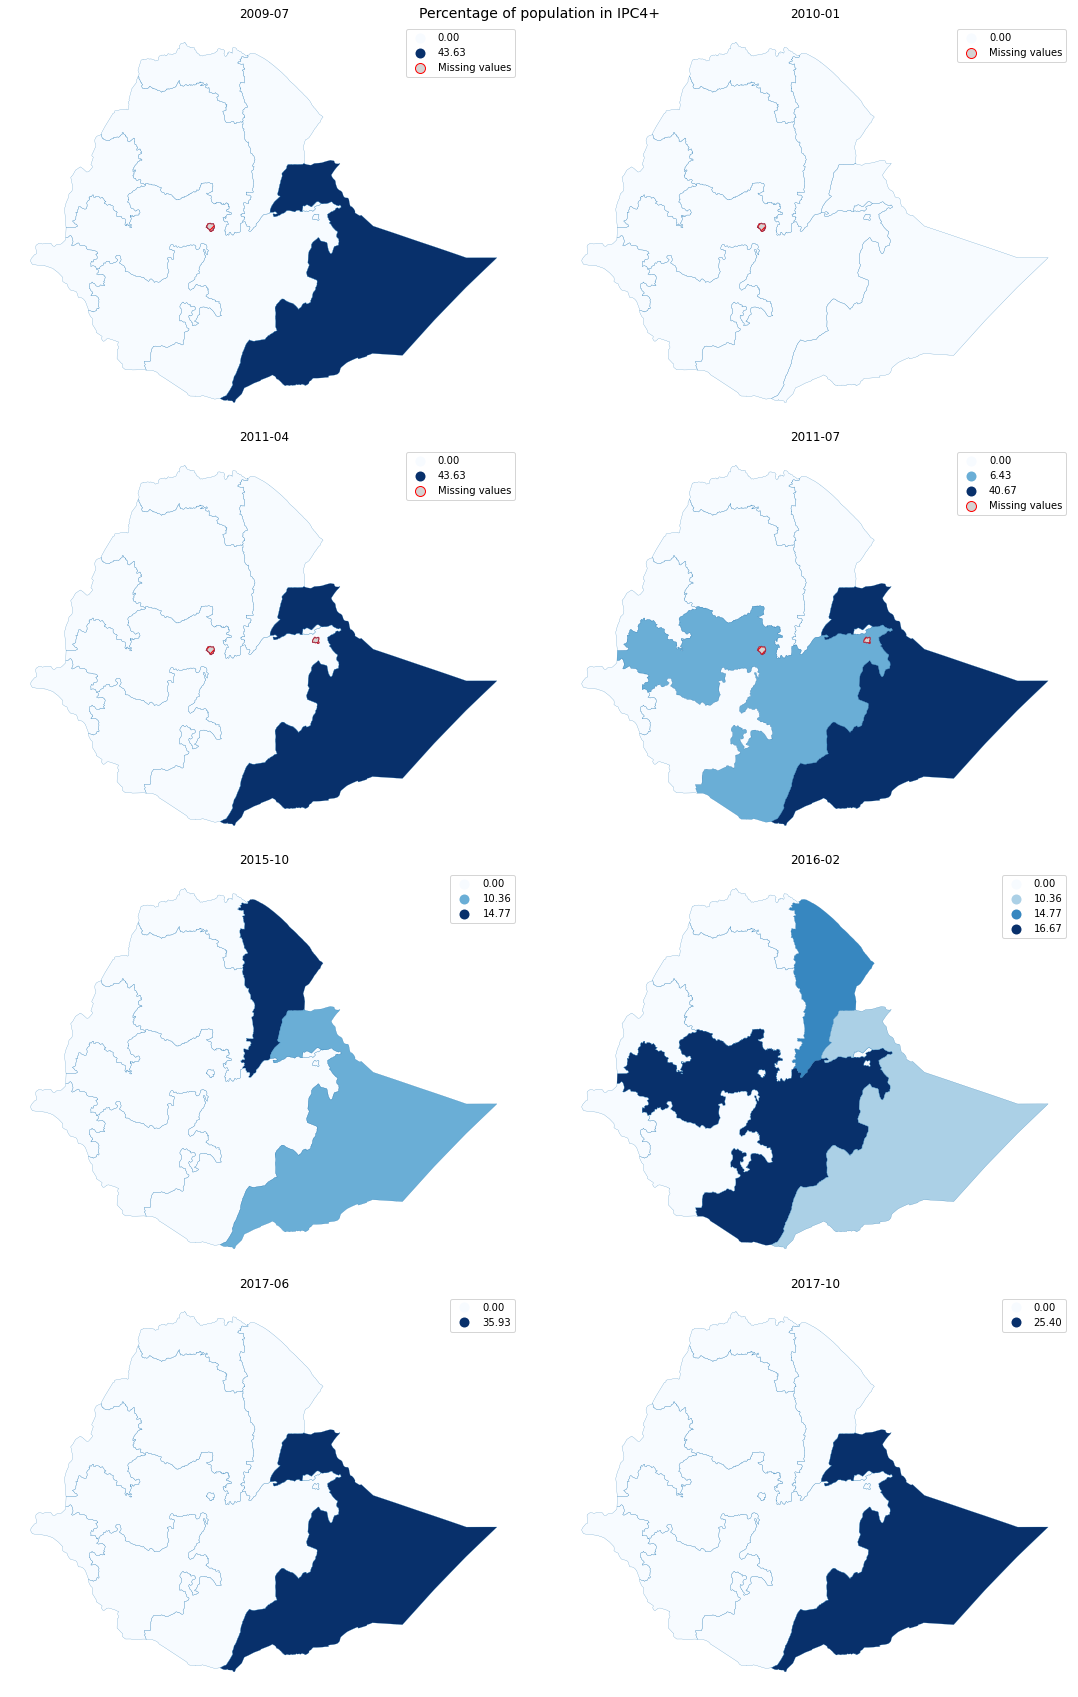

In [380]:
plot_aff_dates(df_ipc,dict_an["an2"]["df"],"perc_CS_4",title="Percentage of population in IPC4+")#dict_an["an3"]["trig_cols"])

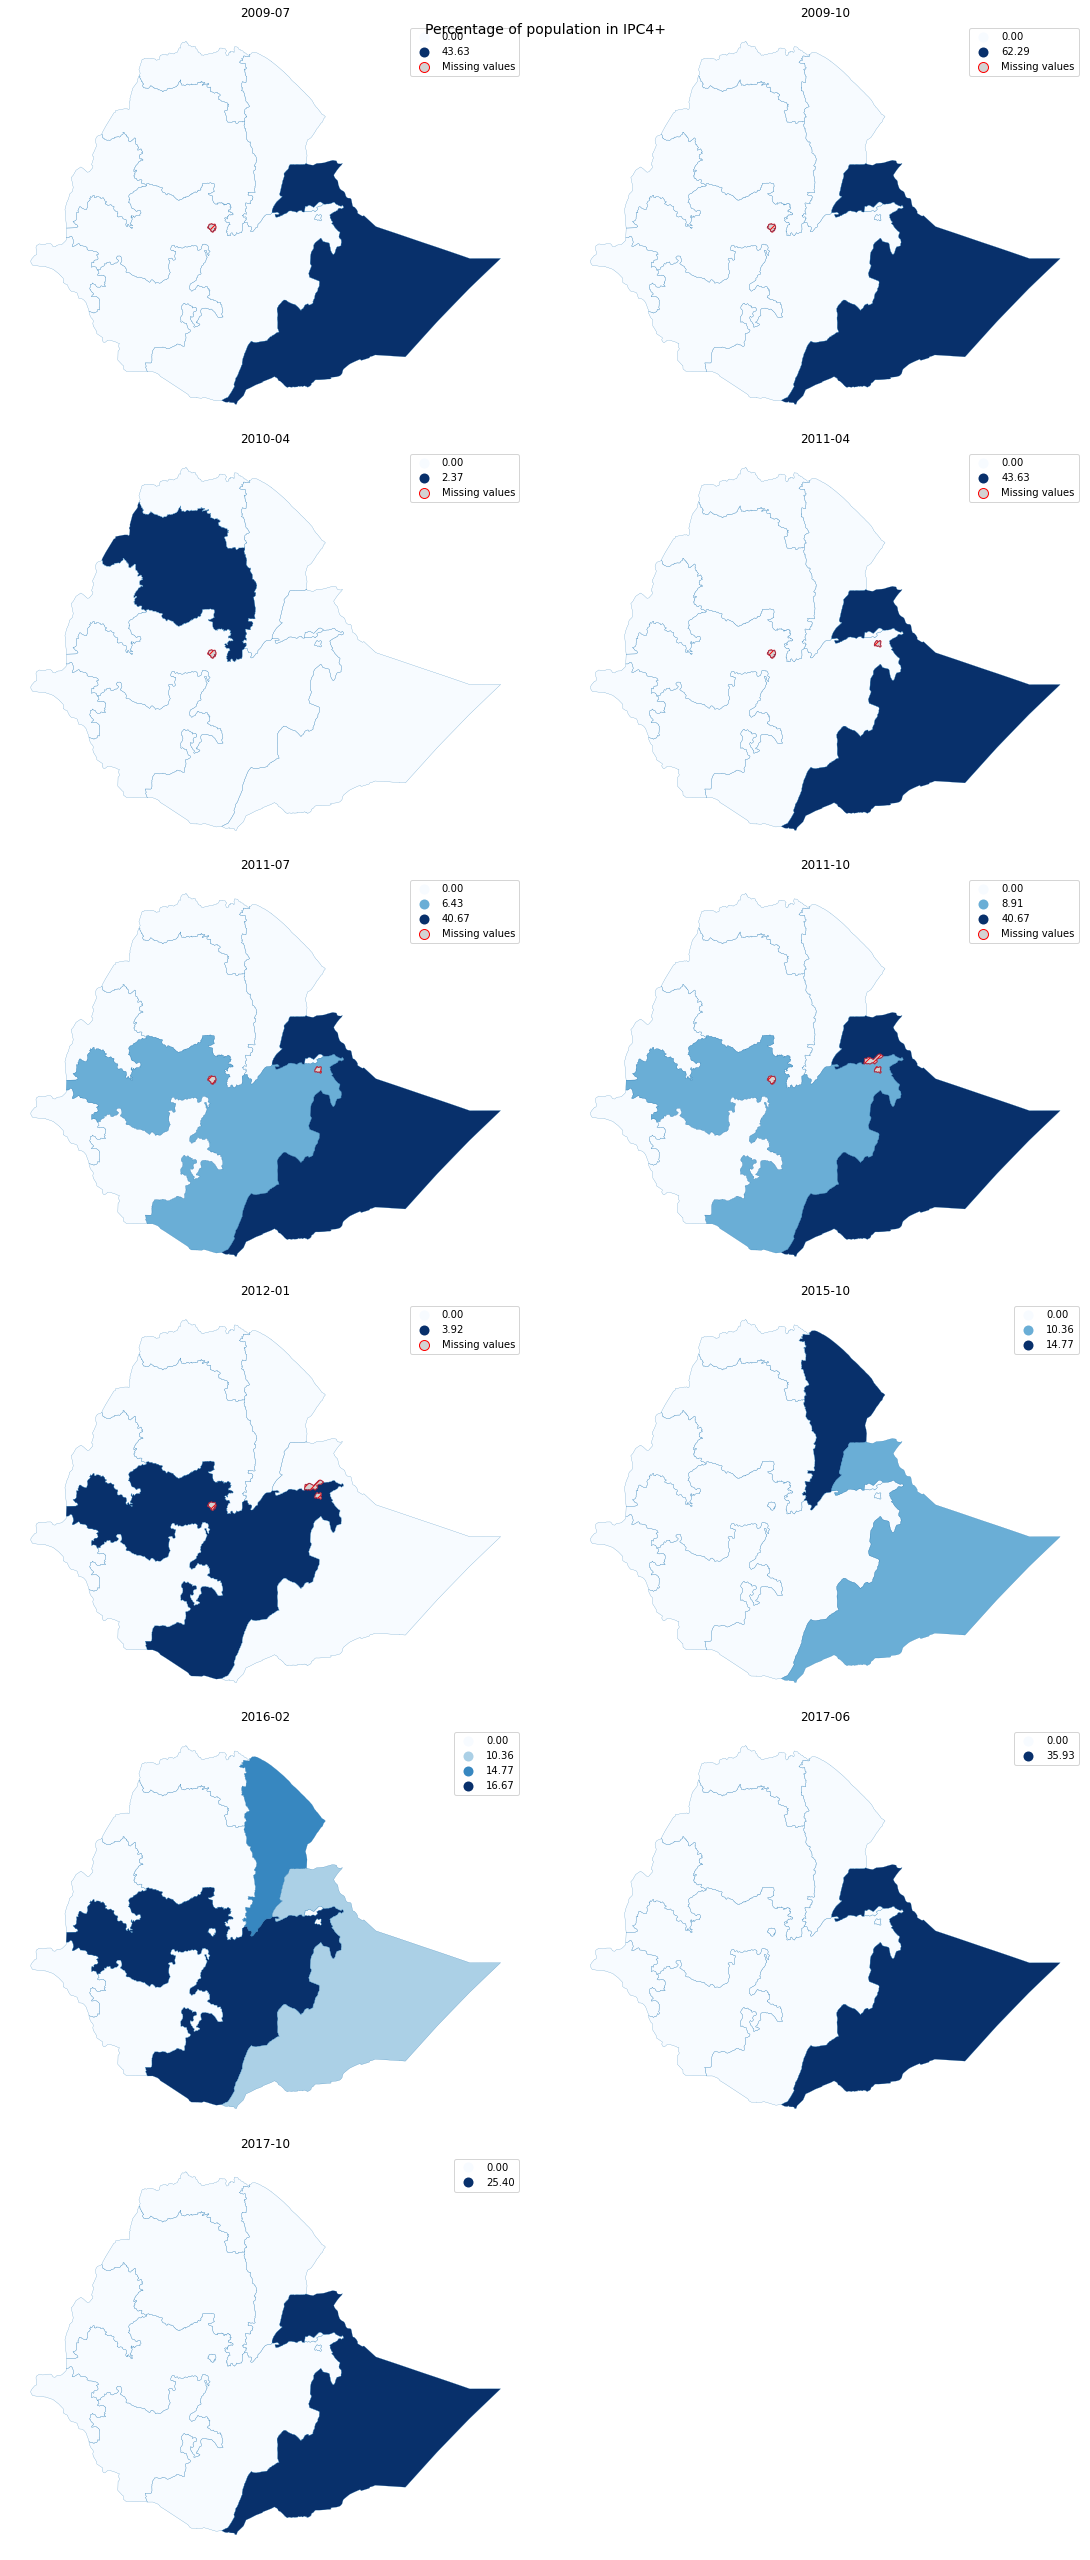

In [382]:
plot_aff_dates(df_ipc,dict_an["an4"]["df"],"perc_CS_4",title="Percentage of population in IPC4+")#dict_an["an3"]["trig_cols"])

No not-NaN values for 2018-12-01T00:00:00.000000000


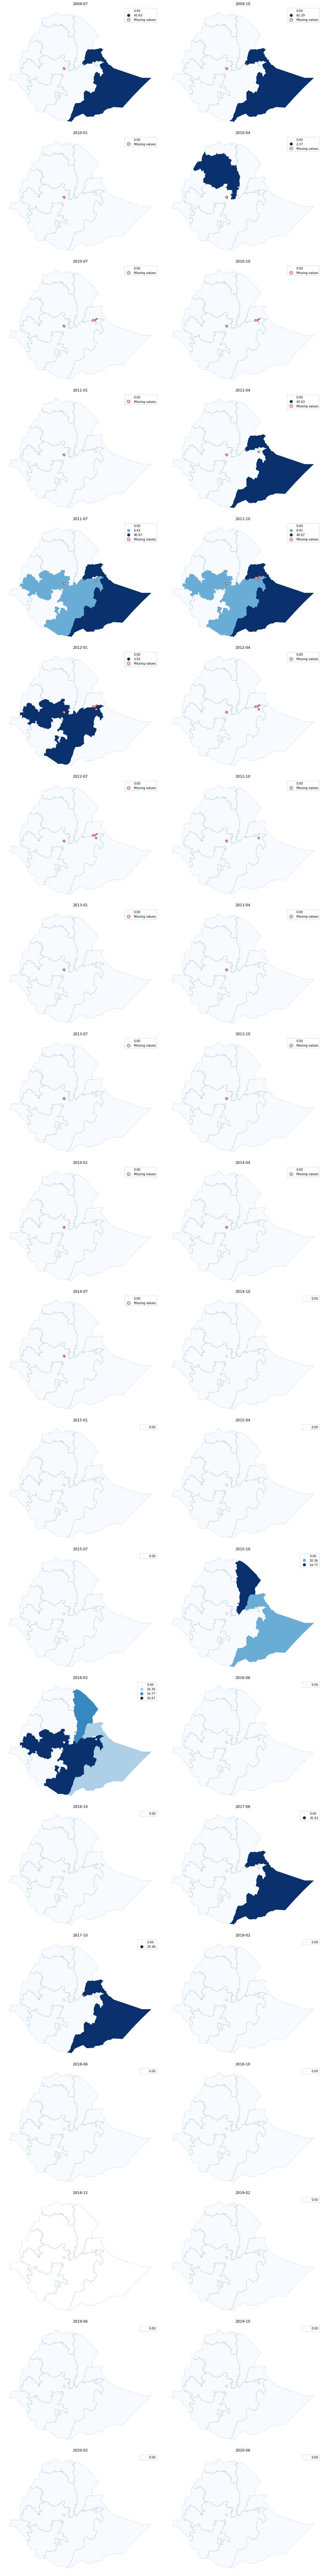

In [381]:
plot_aff_dates(df_ipc,df_ipc,"perc_CS_4")

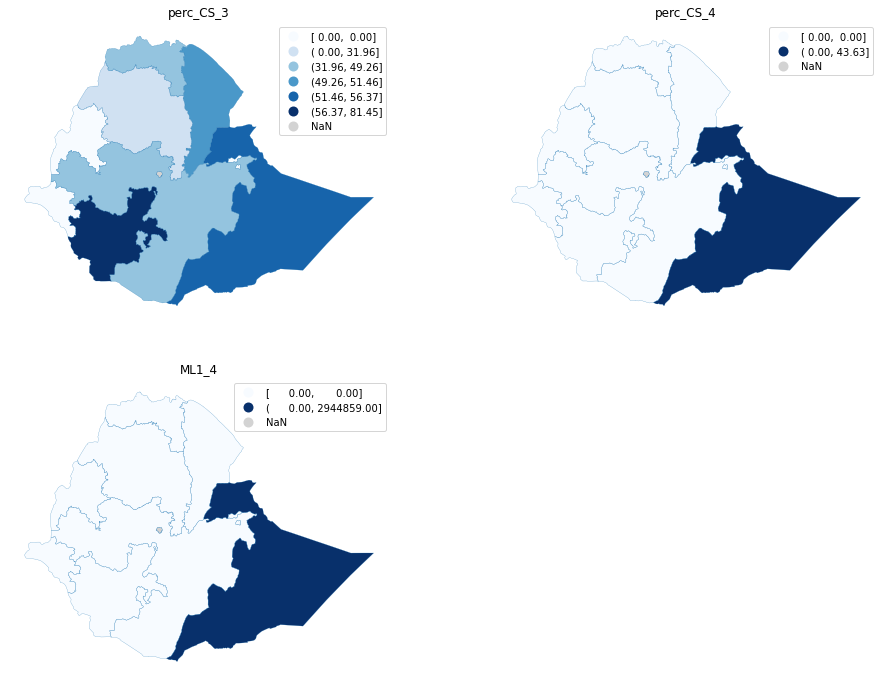

In [38]:
plot_aff_collist(df_ipc[df_ipc.date=="2009-07"],["perc_CS_3","perc_CS_4","ML1_4"])

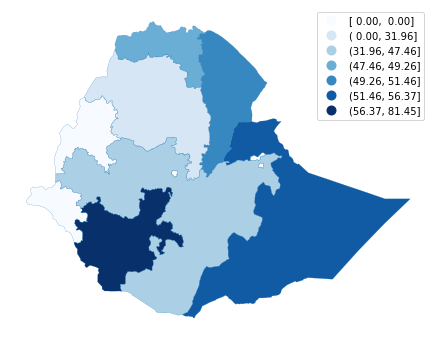

In [33]:
plot_aff_col(df_ipc[df_ipc.date=="2009-07"],"perc_CS_3")

In [27]:
df_ipc["perc_CS4"].value_counts().sort_index()

0.000000     402
2.370135       1
3.917398       1
6.429119       1
8.905067       1
10.363119      1
10.363126      1
14.773934      1
14.773947      1
16.670121      1
25.397149      1
35.931005      1
40.672921      2
43.631949      1
43.631971      1
62.292534      1
Name: perc_CS4, dtype: int64

In [21]:
# sns.distplot(df_ipc["perc_CS4"])#,binwidth=1)#,x="perc_CS4")

In [338]:
def plot_regions_trig(df_trig,adm0c="ADM0_EN",adm1c="ADM1_EN",shape_path="Data/ET_Admin2_OCHA_2019/eth_admbnda_adm2_csa_bofed_20190827.shp"):
     #'ET_Admin2_2014/ET_Admin2_2014.shp'
    gdf = gpd.read_file(shape_path)

    count = 1
    f, ax = plt.subplots(figsize=(12,12))
    for d in ['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']:
        ax2 = plt.subplot(4, 4, count)
        gdf.plot(ax=ax2, color='#DDDDDD', edgecolor='#BBBBBB')
        regions = df_trig[adm1c].loc[df_trig['year'].astype(str)==d]
        gdf.loc[gdf[adm1c].isin(regions)].plot(ax=ax2, color='red')
        plt.title("Regions triggered")
        count+=1
    plt.show()

/Users/tinkavalentijn/opt/anaconda3/envs/aafi/lib/python3.8/site-packages/geopandas/plotting.py:484: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/Users/tinkavalentijn/opt/anaconda3/envs/aafi/lib/python3.8/site-packages/geopandas/plotting.py:484: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/Users/tinkavalentijn/opt/anaconda3/envs/aafi/lib/python3.8/site-packages/geopandas/plotting.py:484: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/Users/tinkavalentijn/opt/anaconda3/envs/aafi/lib/python3.8/site-packages/geopandas/plotting.py:484: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/Users/tinkavalentijn/opt/anaconda3/envs/aafi/lib/python3.8/site-packages/geopandas/plotting.py:484: UserWarning: The GeoDataFrame you are attemptin

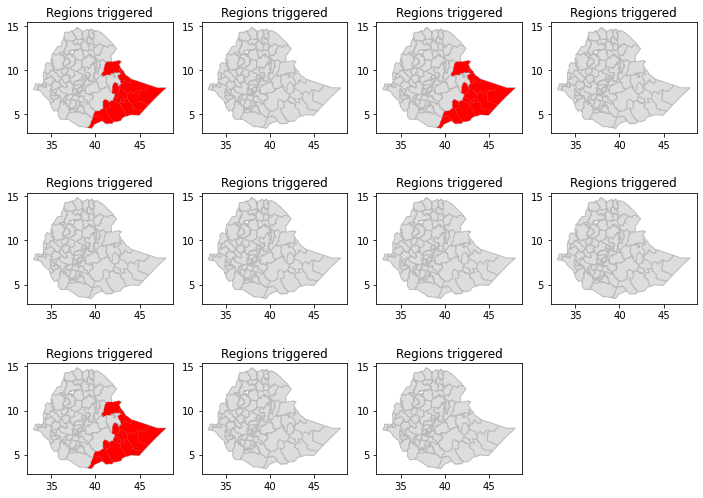

In [339]:
plot_regions_trig(df_snCS420)

In [99]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

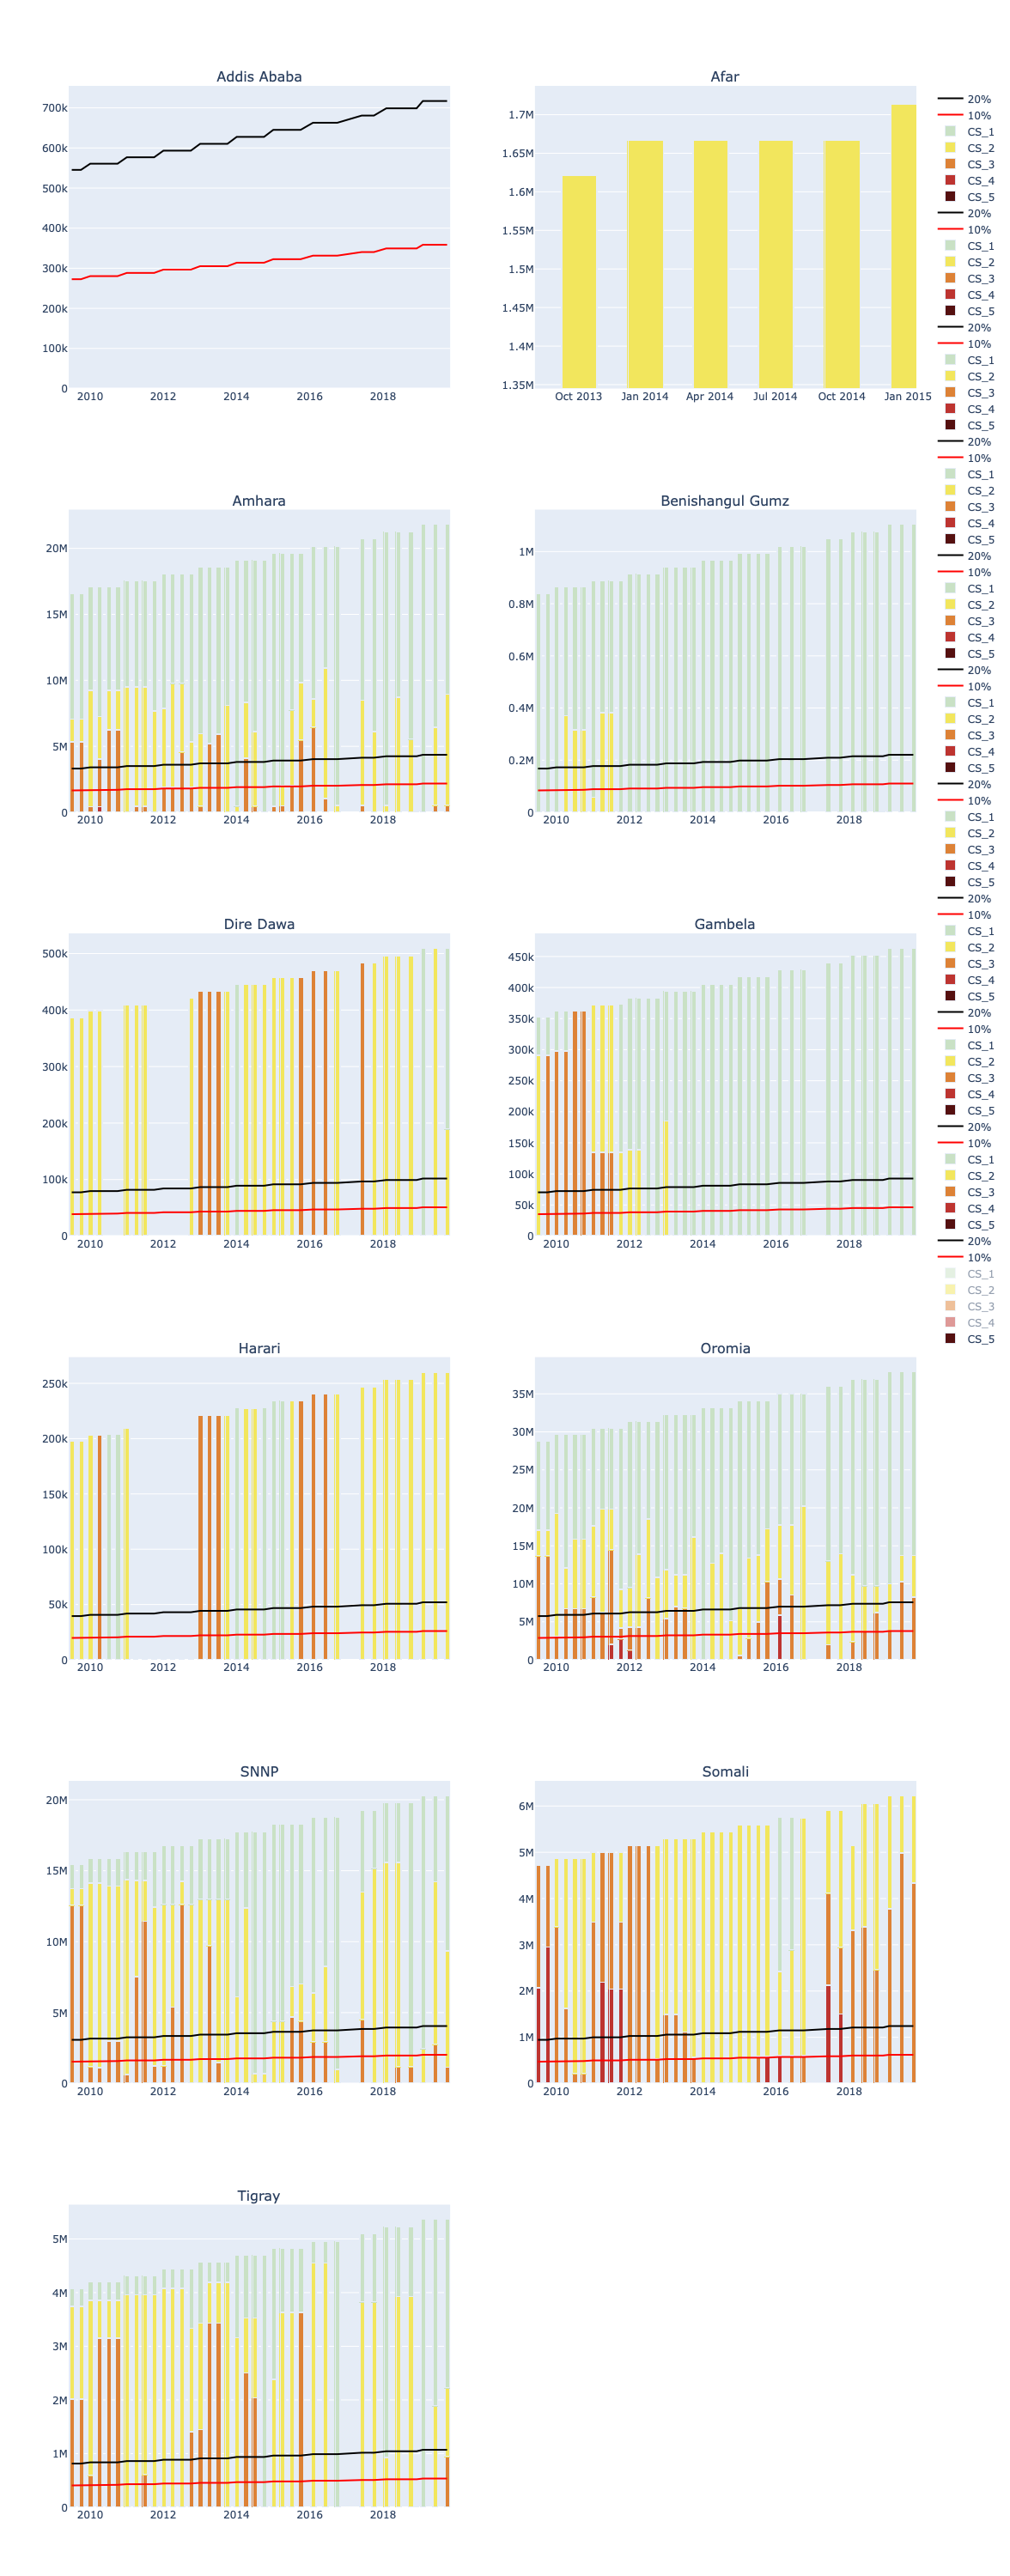

In [149]:
# data=df_ipc[df_ipc.ADM1_EN=="Oromia"]
colp_num=2
num_adm=len(df_ipc.ADM1_EN.unique())
rows=num_adm // colp_num
rows+=num_adm % colp_num
fig = make_subplots(
    rows=rows, cols=colp_num,subplot_titles=list(df_ipc.ADM1_EN.unique()),vertical_spacing=0.05)
for k,a in enumerate(df_ipc.ADM1_EN.unique()):
    col = k%colp_num + 1
    row = int(str((k/colp_num) + 1)[0])
#     print(k)
    data=df_ipc[df_ipc.ADM1_EN==a]
    CS_list=[]
    color_map = {1:'#C9E1C5', 2:'#F2E65D', 3:'#DD8236', 4:'#BD3430', 5:'#551010', 99: '#CCCCCC'}
    for i in range(5,0,-1):
        fig.add_trace(go.Bar(name=f'CS_{i}',x=data["date"],y=data[f"CS_{i}"],marker_color=color_map[i]),row=row,col=col)
    fig.add_trace(go.Scatter(x=data['date'], y=data['adjusted_population']/10,line=dict(
                    color='Red'),name="10%"),row=row,col=col)
    fig.add_trace(go.Scatter(x=data['date'], y=data['adjusted_population']/5,line=dict(
                    color='black'),name="20%"),row=row,col=col)
#     fig.add_trace(data=CS_list,row=k,col=1)
# Change the bar mode
fig.update_layout(barmode='stack',width=1000,height=3000)
fig.show()

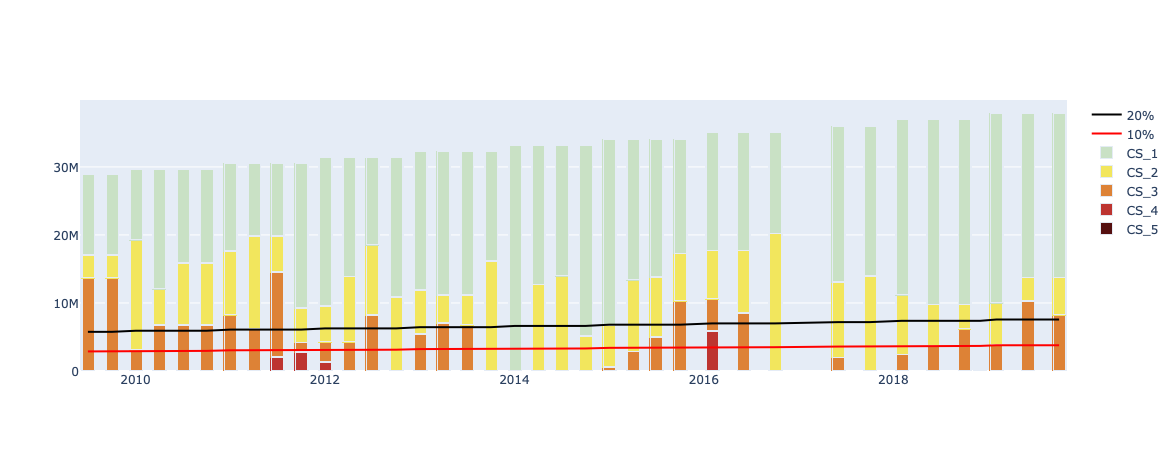

In [36]:
data=df_ipc[df_ipc.ADM1_EN=="Oromia"]
CS_list=[]
color_map = {1:'#C9E1C5', 2:'#F2E65D', 3:'#DD8236', 4:'#BD3430', 5:'#551010', 99: '#CCCCCC'}
for i in range(5,0,-1):
    CS_list.append(go.Bar(name=f'CS_{i}',x=data["date"],y=data[f"CS_{i}"],marker_color=color_map[i]))
CS_list.append(go.Scatter(x=data['date'], y=data['adjusted_population']/10,line=dict(
                color='Red'),name="10%"))
CS_list.append(go.Scatter(x=data['date'], y=data['adjusted_population']/5,line=dict(
                color='black'),name="20%"))
fig = go.Figure(data=CS_list)
# Change the bar mode
fig.update_layout(barmode='stack')
fig.show()

In [88]:
def plot_ipclevels(df,adm1c="ADM1_EN"):
    color_map = {1:'#C9E1C5', 2:'#F2E65D', 3:'#DD8236', 4:'#BD3430', 5:'#551010', 99: '#CCCCCC'}
    width = 75
    count = 1
    fig, ax = plt.subplots(figsize=(15,30))
    plt.suptitle('Ethiopia Triggers at Admin1 Level')
    for region in df[adm1c].unique():
        ax = plt.subplot(6,2,count)
        data = df.loc[df[adm1c]==region]
#         total = data['CS_1']+data['CS_2']+data['CS_3']+data['CS_4'].to_numpy()
#         plt.bar(data["date"],data["CS_5"],width=width, color=color_map[5])
#         for i in range(4,0,-1):
#             plt.bar(data["date"],data[f"CS_{i}"],width=width, color=color_map[i],bottom=data[[f"CS_{l}" for l in range(i+1, 6)]].sum().to_numpy())
        p4 = plt.bar(data['date'], data['CS_4'], width=width, color=color_map[4],label="IPC 4")
        p3 = plt.bar(data['date'], data['CS_3'], width=width, color=color_map[3], bottom=data['CS_4'].to_numpy(),label="IPC 3")
        p2 = plt.bar(data['date'], data['CS_2'], width=width, color=color_map[2], bottom=(data['CS_3']+data['CS_4']).to_numpy(),label="IPC 2")
        p1 = plt.bar(data['date'], data['CS_1'], width=width, color=color_map[1], bottom=(data['CS_2']+data['CS_3']+data['CS_4']).to_numpy(),label="IPC 1")
        p5 = plt.plot(data['date'], data['adjusted_population']/10 , color='red',label="10%")
        p6 = plt.plot(data['date'], data['adjusted_population']/5, color='black',label="20%")
        plt.title(region + ' Current Situation')
#         ax.legend((p1[0], p2[0], p3[0], p4[0], p5[0], p6[0]), ('IPC 1', 'IPC 2', 'IPC 3', 'IPC 4', '10 %', '20 %'),loc="upper right")
        ax.legend(loc="upper right")
        ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        count+=1

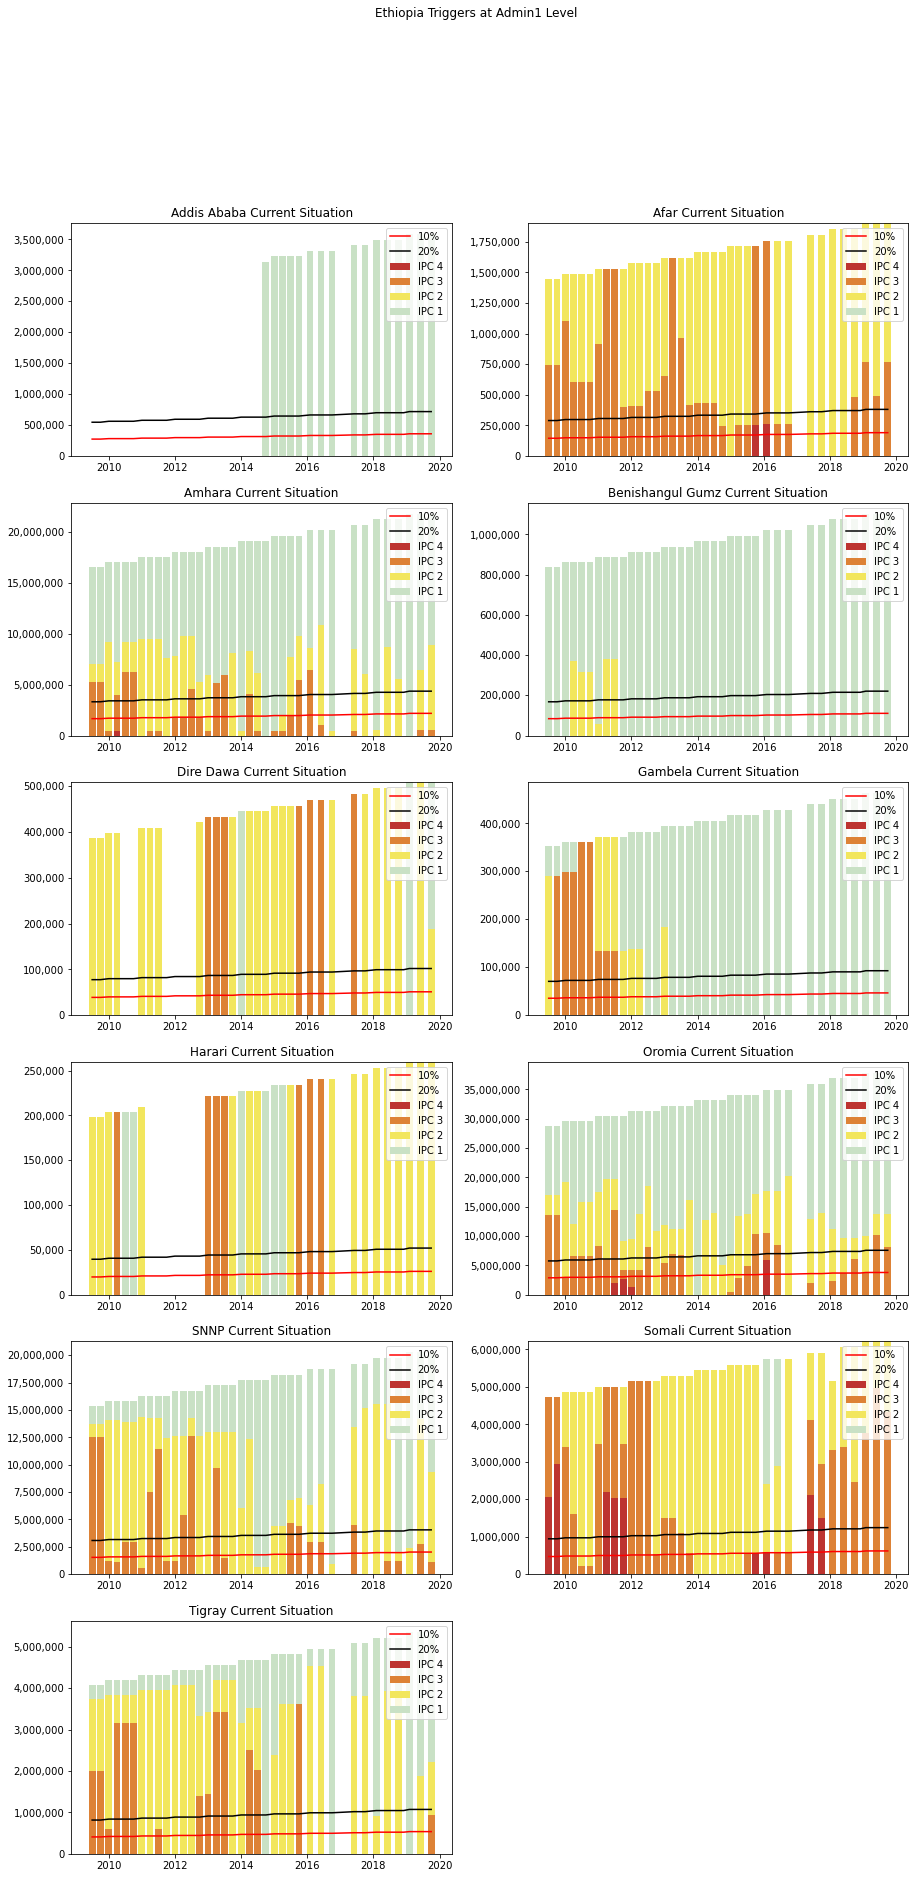

In [89]:
plot_ipclevels(df_ipc)

### Missing data

In [54]:
print("Number of date-admin1 combinations with no IPC CS data:", len(df_ipc[df_ipc.total_pop==0]))

Number of date-admin1 combinations with no IPC CS data: 45


In [57]:
print("Percentage of missing data:",len(df_ipc[df_ipc.total_pop==0])/len(df_ipc)*100)

Percentage of missing data: 10.76555023923445
